In [1]:
from pyopenms import *
import os
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

In [2]:
def process_files_in_folder(folder_path):
    # Get a list of all files in the specified folder
    files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

    # Process each file
    df = pd.DataFrame({"File":[], "SpectrumID":[], "Sequence":[], "spectrum_q" : [], "charge": [], "MZ":[]})
    for file_name in files:
        file_path = os.path.join(folder_path, file_name)
        
        
        if file_name.endswith(".idXML") and "FDR" in file_name:
            df = pd.concat([df,read_idxml_file(file_path, file_name)], ignore_index=True)
        if file_name.endswith(".csv") :
            
            concat_csv = pd.read_csv(file_path)
            concat_csv2 = pd.DataFrame({"File":file_name[-7:-4], "SpectrumID" : concat_csv["SpectrumID"], "Sequence" : concat_csv[" Sequence"]})
            df = pd.concat([df, concat_csv2])
    
    return df

def read_idxml_file(idxml_file_path, file):
    idxml_file = IdXMLFile()

    # Create an MSExperiment object to store the data
    experiment = []
    protein_ids= []
    
    # Read the idXML file
    idxml_file.load(idxml_file_path,protein_ids, experiment)
    
    ids = []
    sequences = []
    score = []
    mz = []
    charge =[]

    # Access the data in the experiment object
    for spectrum in experiment:
        
        
        for peptide_hit in spectrum.getHits():
            ids.append(spectrum.getMetaValue("spectrum_reference"))
            
            sequences.append(peptide_hit.getSequence().toString())
            score.append(peptide_hit.getScore())
            mz.append(spectrum.getMZ())
            charge.append(peptide_hit.getCharge())
    return pd.DataFrame({"File": file, "SpectrumID": ids, "Sequence" : sequences, "spectrum_q": score, "charge":charge, "MZ":mz})
    





We first make the diagram for the regular search on the regular dataset

In [4]:
closed_pse = process_files_in_folder("temp_data/PeptideSearch/")
closed_sse = process_files_in_folder("temp_data/SimpleSearch/")
closed_sage = pd.read_csv("temp_data/results.sage_decoy.tsv", sep = "\t")

In [5]:
closed_sage = closed_sage[closed_sage['matched_peaks'] > 5]

In [3]:
def generate_y_axis(df, x_min, x_max, steps):
    y_axis = []
    x_axis = []
    i = x_min
    while i <= x_max:
        y_axis.append(sum(df["spectrum_q"] <= i))
        x_axis.append(i)
        i += (x_max - x_min)/100
    return x_axis, y_axis




In [6]:
min_x = min(min(closed_pse["spectrum_q"]), min(closed_sse["spectrum_q"]), min(closed_sage["spectrum_q"]))
max_x = max(max(closed_pse["spectrum_q"]), max(closed_sse["spectrum_q"]), max(closed_sage["spectrum_q"]))
x, closed_pse_y = generate_y_axis(closed_pse, min_x, 0.01, 100)
_, closed_sse_y = generate_y_axis(closed_sse, min_x, 0.01, 100)
_, closed_sage_y = generate_y_axis(closed_sage, min_x, 0.01, 100)

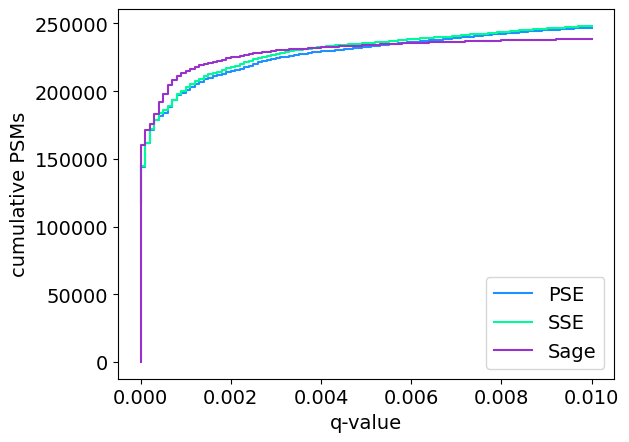

In [12]:
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 
plt.step(x, closed_pse_y, label = "PSE", color = 'dodgerblue')
plt.step(x, closed_sse_y, label = "SSE", color = 'mediumspringgreen')
plt.step(x, closed_sage_y, label = "Sage", color = 'darkorchid')
plt.ylabel("cumulative PSMs", size = 14)
plt.xlabel("q-value", size = 14)

plt.legend(fontsize = 14)
plt.savefig("FIID_closed_cumulative_hits.png", bbox_inches = 'tight', dpi = 700)

In [8]:
open_pse = read_idxml_file("bottom_up_open/b1906_293T_fixed_FDR_0.02.idXML", "b1906")
open_sage = pd.read_csv("bottom_up_open/results.sage_open.tsv", sep = "\t")
open_pse_fixed = read_idxml_file("bottom_up_open/b1906_293T_fixed_FDR.idXML", "b1906")
open_sage_fixed = pd.read_csv("bottom_up_open/results.sage_openfixed.tsv", sep = "\t")

In [9]:
open_sage = open_sage[open_sage['matched_peaks'] > 5]
open_sage_fixed = open_sage_fixed[open_sage_fixed['matched_peaks'] > 5]

In [10]:
open_min_x = min(min(open_pse['spectrum_q']), min(open_sage['spectrum_q']), min(open_pse_fixed['spectrum_q']), min(open_sage_fixed['spectrum_q']))
open_max_x = max(max(open_pse['spectrum_q']), max(open_sage['spectrum_q']), max(open_pse_fixed['spectrum_q']), max(open_sage_fixed['spectrum_q']))
open_x, open_pse_y = generate_y_axis(open_pse, open_min_x, 0.01, 100)
_, open_sage_y = generate_y_axis(open_sage, open_min_x, 0.01, 100)
_, open_pse_fixed_y = generate_y_axis(open_pse_fixed, open_min_x, 0.01, 100)
_, open_sage_fixed_y = generate_y_axis(open_sage_fixed, open_min_x, 0.01, 100)


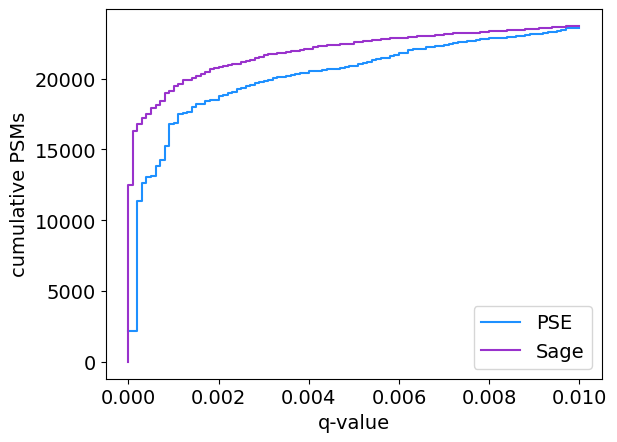

In [11]:
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 
plt.step(open_x, open_pse_fixed_y, label = "PSE", color = 'dodgerblue')
plt.step(open_x, open_sage_fixed_y, label = "Sage", color = 'darkorchid')

plt.ylabel("cumulative PSMs", size = 14)
plt.xlabel("q-value", size = 14)
plt.legend(fontsize = 14)
plt.savefig("FIID_open_cumulative_hits.png", bbox_inches = 'tight', dpi = 700)

# next i am intersted in the PTMS of the identification

In [19]:
def compute_monoisotopic(sequence):     
    amino_acid_masses = {
    'A': 71.03711,
    'R': 156.10111,
    'N': 114.04293,
    'D': 115.02694,
    'C': 103.00919,
    'E': 129.04259,
    'Q': 128.05858,
    'G': 57.02146,
    'H': 137.05891,
    'I': 113.08406,
    'L': 113.08406,
    'K': 128.09496,
    'M': 131.04049,
    'F': 147.06841,
    'P': 97.05276,
    'S': 87.03203,
    'T': 101.04768,
    'W': 186.07931,
    'Y': 163.06333,
    'V': 99.06841,
    'U' : 150.95363

    }
    modis = {
        '(Carbamidomethyl)' : 57.0215,
        '(Oxidation)' : 15.9949
    }
    mass = 0
    aa = 0
    while aa < len(sequence):
        if sequence[aa] == '(':
            start = aa
            while sequence[aa] != ')':
                aa += 1
            end = aa
            mass += modis[sequence[start:(end+1)]]
        else:
            mass += amino_acid_masses[sequence[aa]]
        aa +=1
    return mass + 19

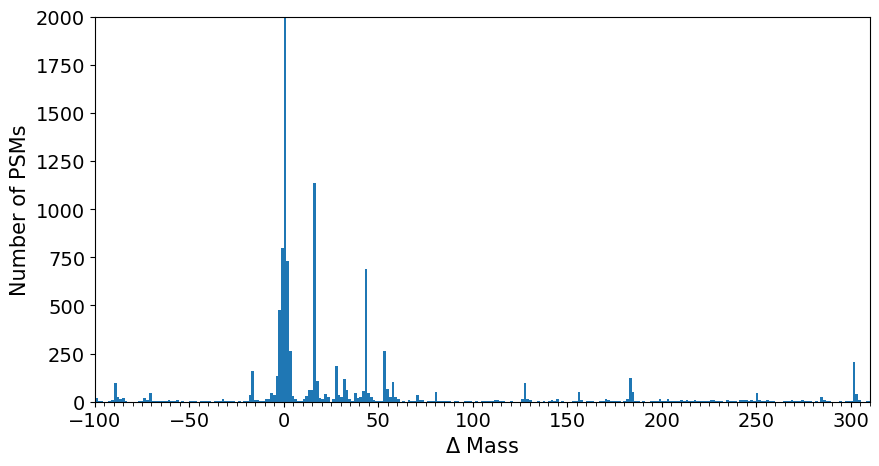

In [22]:

fig, ax = plt.subplots(figsize = (10, 5))

bins = ax.hist([x['MZ']*x['charge'] -(x['charge']-1) - compute_monoisotopic(x['Sequence']) for i, x in open_pse_fixed.iterrows()], bins = 700)
ax.set_xlim(-100, 310)
ax.set_ylim(0, 2000)

ax.xaxis.set_minor_locator(AutoMinorLocator(10)) 
ax.tick_params(which='minor', length=3)
ax.set_xlabel(r'$\Delta$ Mass', size = 15)
ax.set_ylabel('Number of PSMs',size = 15)
plt.savefig("FIID_open_modification_histo.png", bbox_inches = 'tight', dpi = 500)



In [119]:
sorted(zip(bins[0], bins[1]), reverse= True)

[(13746.0, -0.04788229999996929),
 (1138.0, 15.644852600857234),
 (800.0, -1.474494563714245),
 (732.0, 1.3787299637143065),
 (691.0, 42.750485611428644),
 (475.0, -2.9011068274285208),
 (266.0, 2.805342227428582),
 (261.0, 52.73677145742863),
 (206.0, 300.9673053437143),
 (185.0, 27.05775071057144),
 (159.0, -17.167229464571392),
 (132.0, -4.3277190911427965),
 (124.0, 182.55848745542858),
 (120.0, 31.337587501714324),
 (106.0, 17.071464864571453),
 (103.0, 57.016608248571515),
 (97.0, -89.92445491399997),
 (96.0, 126.92060917057142),
 (74.0, -114.17686339714282),
 (68.0, 54.16338372114285),
 (62.0, 14.218240337142902),
 (60.0, 32.76419976542866),
 (59.0, 12.79162807342857),
 (58.0, 41.32387334771431),
 (53.0, 155.45285444485717),
 (52.0, 79.84240446800004),
 (52.0, -128.44298603428564),
 (49.0, 183.9850997191429),
 (45.0, -7.180943618571405),
 (43.0, 249.60926385000005),
 (43.0, 44.17709787514286),
 (43.0, 37.04403655657143),
 (43.0, -71.37849548571421),
 (40.0, 302.39391760742853),
